In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import ultranest
from ultranest.plot import cornerplot

In [3]:
# Get haslam map and use it to generate sky temperature cube in 10-100 MHz
def map_remazeilles_408MHz(map_file, galactic_coord_file):

    '''

    This function will return the Haslam map reprocessd by Remazeilles et al. (2014) in NESTED Galactic Coordinates. But the input data is in RING coordinates.

    This version is only destriped, not desourced.

    Example of input data:
    ----------------------
    map_file            = edges_folder + '/sky_models/haslam_map/haslam408_ds_Remazeilles2014.fits'
    galactic_coord_file = edges_folder + '/sky_models/coordinate_maps/pixel_coords_map_ring_galactic_res9.fits'


    '''


    # Loading NESTED galactic coordinates
    # -----------------------------------
    coord              = fits.open(galactic_coord_file)
    coord_array        = coord[1].data
    lon_ring           = coord_array['LONGITUDE']
    lat_ring           = coord_array['LATITUDE']

    lon = hp.reorder(lon_ring, r2n=True)
    lat = hp.reorder(lat_ring, r2n=True)
 

    # GALAC_COORD_object = apc.SkyCoord(lon, lat, frame='galactic', unit='deg')  # defaults to ICRS frame



    # Loading Haslam map
    # ------------------
    haslam_map = fits.open(map_file)
    x  = (haslam_map[1].data)['temperature']
    haslam408_ring = x.flatten()

    haslam408 = hp.reorder(haslam408_ring, r2n=True)


    print('REMAZEILLES 408MHz MAP')


    return haslam408, lon, lat

map_file = "haslam408_ds_Remazeilles2014.fits"
galactic_coord_file = "pixel_coords_map_ring_galactic_res9.fits"
hl, long, lat = map_remazeilles_408MHz(map_file,galactic_coord_file)

nu = np.arange(10,101,1)
real_map = np.array([hl*(10/408)**(-2.5)])
for i in np.arange(11,101,1):
    real_map = np.vstack([real_map,hl*(i/408)**(-2.5)])


REMAZEILLES 408MHz MAP


In [4]:
pmlong = long
for i in range(len(long)):
    if long[i] <= 360 and long[i] >= 180:
        pmlong[i] = long[i] - 360

In [5]:
reduce_map = hp.pixelfunc.ud_grade(real_map, 2**8,order_in = 'NESTED', order_out = 'NESTED')

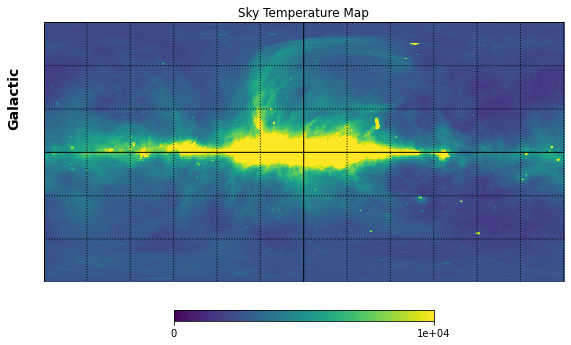

In [6]:
# At 50Mhz, the sky temperature map
hp.cartview(reduce_map[49], 
    title="Sky Temperature Map",
           nest=True,
           min=0,
    max=1e4, coord=["G", "G"])
hp.graticule()

In [7]:
reduce_long = hp.pixelfunc.ud_grade(long, 2**8, order_in = 'NESTED', order_out = 'NESTED')
reduce_lat = hp.pixelfunc.ud_grade(lat, 2**8, order_in = 'NESTED', order_out = 'NESTED')

In [8]:
# Generate 2D Gaussian Beam Cube plane
freq = np.array(range(10,101))
x0 = 0
y0 = 0
slope = 0.3
intercept = 7.5
sigx = slope * freq + intercept
sigy = sigx

In [9]:
# Convolution to generate curve
def reduce_convolution(slope, intercept, sky):
    x = np.ones(91)
    for i in range(91):
        sig = slope * freq + intercept
        lat_ = np.exp(-(reduce_lat**2/(2*(sig[i]**2))))
        long_ = np.exp((-reduce_long**2/(2*sig[i]**2)))
        bc = lat_*long_* 5
        x[i] = np.sum(bc*sky[i])/np.sum(bc)
    return x

In [10]:
curve2 = reduce_convolution(slope,intercept,reduce_map)

In [31]:
curve2

array([1521828.        , 1177627.75      ,  930878.0625    ,
        749137.25      ,  612178.5625    ,  506921.53125   ,
        424639.71875   ,  359352.40625   ,  306863.3125    ,
        264166.625     ,  229069.21875   ,  199944.8125    ,
        175568.96875   ,  155008.140625  ,  137541.203125  ,
        122605.5078125 ,  109757.0234375 ,   98642.5546875 ,
         88978.3515625 ,   80534.8203125 ,   73124.8515625 ,
         66594.6640625 ,   60817.32421875,   55687.25      ,
         51116.25390625,   47030.125     ,   43366.2265625 ,
         40071.421875  ,   37100.3984375 ,   34414.36328125,
         31979.97070312,   29768.48242188,   27754.984375  ,
         25917.85742188,   24238.25390625,   22699.66210938,
         21287.66015625,   19989.50195312,   18794.0078125 ,
         17691.24023438,   16672.41210938,   15729.73730469,
         14856.25585938,   14045.75488281,   13292.68945312,
         12592.09375   ,   11939.49609375,   11330.87109375,
         10762.60351562,

In [11]:
# Add Gaussian error to the curve
dt = 1
dnu = 1e6
sigma2 = curve2/np.sqrt(dnu*dt)
data2 = np.random.normal(curve2, sigma2) 
noise2 = data2 - curve2

In [32]:
data2

array([1522305.65929298, 1178392.15425227,  931097.55570173,
        749544.41237448,  612106.11075502,  507281.29641468,
        424986.45616128,  359242.88275039,  307317.22188097,
        264168.20829108,  229055.67323941,  200036.47915006,
        176012.40822268,  155012.68863487,  137341.0101817 ,
        122474.60511545,  109719.95900955,   98581.63226801,
         89175.68133965,   80476.03627696,   73052.41263333,
         66613.74752099,   60733.90859885,   55690.66844818,
         51138.49573402,   47058.18918081,   43468.53240536,
         39986.34949092,   37134.64979614,   34427.84718379,
         31929.24977925,   29744.79816882,   27775.32940046,
         25891.69955893,   24283.46738974,   22642.71825971,
         21286.69688962,   19971.08315982,   18787.87418433,
         17686.82042842,   16698.29381416,   15757.59255858,
         14838.56621446,   14052.72053781,   13286.72841287,
         12579.24233738,   11923.92560924,   11327.53125922,
         10750.51436478,

In [12]:
# Define model to simulate data
def model2(paras, nu):
    slope,intercept = paras
    return reduce_convolution(slope, intercept, reduce_map)

In [13]:
param_names = ['m', 'n']
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 1
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = 5
    hi = 10
    params[1] = cube[1] * (hi - lo) + lo

    return params
def my_likelihood(params):
    mo = model2(params, nu)
    diff = mo - data2
    return -0.5 * np.sum((diff/sigma2)**2)

In [14]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)

In [15]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-51.2566..-51.2566]*| it/evals=7564/10566 eff=74.4049% N=400                      
[ultranest] Likelihood function evaluations: 10566
[ultranest]   logZ = -65.53 +- 0.144
[ultranest] Effective samples strategy satisfied (ESS = 1583.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -65.560 +- 0.300
  single instance: logZ = -65.560 +- 0.183
  bootstrapped   : logZ = -65.526 +- 0.300
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    m                   : 0.29964│ ▁▁ ▁▁▁▁▁▁▁▂▃▄▄▅▅▇▇▇▇▆▇▇▆▄▃▃▂▁▁▁▁▁▁▁▁▁ │0.30075    0.30021 +- 0.00014
    n                   : 7.4663│ ▁ ▁▁▁▁▁▁▁▁▂▃▄▅▅▆▆▇▇▇▇▆▅▅▃▃▂▁▁▁▁▁▁▁▁▁▁ │7.5170    7.4914 +- 0.0059



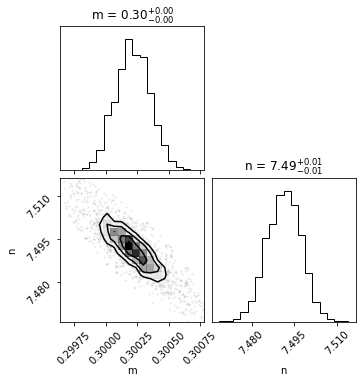

In [16]:
cornerplot(result)

In [20]:
np.savez("min_live_400", result)

In [22]:
# true value
my_likelihood([0.3, 7.5])

-52.53795072724194

In [23]:
#400
my_likelihood([0.30021, 7.4914])

-51.25155845952316

In [26]:
# BIC for 400
- 1/2 * my_likelihood([0.30021, 7.4914]) + 2 * np.log(91)

34.64749824279528

In [19]:
result

{'niter': 7965,
 'logz': -65.55970660085536,
 'logzerr': 0.29998848598602795,
 'logz_bs': -65.52582772588032,
 'logz_single': -65.55970660085536,
 'logzerr_tail': 0.009950023868526614,
 'logzerr_bs': 0.29982342928664707,
 'ess': 1583.1294012528324,
 'H': 13.329508546165009,
 'Herr': 0.14130012095546798,
 'posterior': {'mean': [0.3002147353332174, 7.491385445875539],
  'stdev': [0.00013736250793339844, 0.0058979877683263465],
  'median': [0.30021313722623133, 7.491616703907022],
  'errlo': [0.3000719140391642, 7.485222405349141],
  'errup': [0.3003485186519223, 7.497284467874497],
  'information_gain_bits': [4.14647919764959, 4.14647919764959]},
 'weighted_samples': {'upoints': array([[0.01639287, 0.20193325],
         [0.026723  , 0.06833019],
         [0.03327513, 0.11200955],
         ...,
         [0.30021522, 0.49828238],
         [0.30021926, 0.4982733 ],
         [0.30022042, 0.49826208]]),
  'points': array([[0.01639287, 6.00966624],
         [0.026723  , 5.34165093],
         [

In [27]:
result["samples"].shape

(7965, 2)

(array([   7.,   42.,  340., 1152., 2054., 2131., 1456.,  642.,  120.,
          21.]),
 array([0.2996864 , 0.29978811, 0.29988982, 0.29999152, 0.30009323,
        0.30019494, 0.30029665, 0.30039836, 0.30050007, 0.30060177,
        0.30070348]),
 <BarContainer object of 10 artists>)

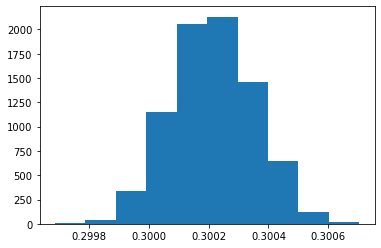

In [28]:
plt.hist(result["samples"][:,0])

(array([   6.,   80.,  421., 1409., 2082., 2288., 1299.,  337.,   37.,
           6.]),
 array([7.46858894, 7.47319788, 7.47780682, 7.48241576, 7.4870247 ,
        7.49163365, 7.49624259, 7.50085153, 7.50546047, 7.51006941,
        7.51467835]),
 <BarContainer object of 10 artists>)

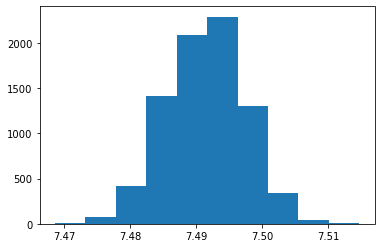

In [29]:
plt.hist(result["samples"][:,1])

In [30]:
result = sampler.run(min_num_live_points=200)

[ultranest] Widening roots to 200 live points (have 400 already) ...
[ultranest] Explored until L=-5e+01  
[ultranest] Likelihood function evaluations: 10566
[ultranest]   logZ = -65.52 +- 0.1199
[ultranest] Effective samples strategy satisfied (ESS = 1583.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.


In [20]:
sampler.print_results()


logZ = -68.224 +- 0.437
  single instance: logZ = -68.224 +- 0.259
  bootstrapped   : logZ = -68.252 +- 0.437
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    m                   : 0.29971│ ▁▁▁▁▁▁▁▁▂▃▂▄▅▇▅▇▅▇▆▇▆▅▃▄▂▃▂▂▁▁▁▁▁▁  ▁ │0.30078    0.30022 +- 0.00014
    n                   : 7.4669│ ▁ ▁ ▁▁▁▁▁▁▁▂▂▃▄▅▅▅▇▅▇▇▇▆▅▆▅▃▂▂▁▁▁▁▁▁▁ │7.5111    7.4916 +- 0.0058



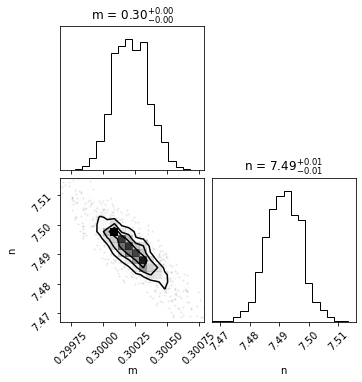

In [22]:
cornerplot(result)

In [93]:
result["samples"].shape

(8072, 2)

In [94]:
sampler.print_results()


logZ = -61.110 +- 0.500
  single instance: logZ = -61.110 +- 0.259
  bootstrapped   : logZ = -61.099 +- 0.500
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    m                   : 0.29952│ ▁▁▁▁▁▁▁▁▂▂▂▃▃▅▆▅▇▇▇▇▆▅▅▃▃▁▂▁▁▁▁▁▁▁ ▁▁ │0.30061    0.30004 +- 0.00013
    n                   : 7.4683│ ▁  ▁▁▁▁▁▁▁▂▂▂▃▄▃▅▆▇▇▇▇▇▅▃▃▂▁▂▂▁▁▁▁▁▁▁ │7.5158    7.4939 +- 0.0057



In [23]:
result

{'niter': 3992,
 'logz': -68.22354106381991,
 'logzerr': 0.437192837652777,
 'logz_bs': -68.25245983285862,
 'logz_single': -68.22354106381991,
 'logzerr_tail': 0.009924268241562118,
 'logzerr_bs': 0.4370801827980273,
 'ess': 791.3001199034572,
 'H': 13.384648843627282,
 'Herr': 0.17015163059445398,
 'posterior': {'mean': [0.30021941235029687, 7.491590361144504],
  'stdev': [0.00013786334262078895, 0.005765718946250598],
  'median': [0.300219321691767, 7.491609139756563],
  'errlo': [0.30008473738641855, 7.4858106688107915],
  'errup': [0.3003550108304227, 7.4974683377192015],
  'information_gain_bits': [4.14647919764959, 4.14647919764959]},
 'weighted_samples': {'upoints': array([[0.0173705 , 0.11811999],
         [0.00972378, 0.28156714],
         [0.0303148 , 0.06285601],
         ...,
         [0.30022561, 0.49834281],
         [0.3002219 , 0.49833553],
         [0.30022209, 0.49833151]]),
  'points': array([[0.0173705 , 5.59059993],
         [0.00972378, 6.40783568],
         [0.0

In [27]:
- 1/2 * my_likelihood([0.30004, 7.4939]) + 2 * np.log(91)

36.85593390112179

In [28]:
- 1/2 * -37.94348724702588 + 2 * np.log(91)

27.99346263654664

In [29]:
my_likelihood([0.3 , 7.5])

-55.171101315928254

In [30]:
my_likelihood([0.30004, 7.4939])

-55.66842977617618

In [34]:
print(result)

{'niter': 3992, 'logz': -68.22354106381991, 'logzerr': 0.437192837652777, 'logz_bs': -68.25245983285862, 'logz_single': -68.22354106381991, 'logzerr_tail': 0.009924268241562118, 'logzerr_bs': 0.4370801827980273, 'ess': 791.3001199034572, 'H': 13.384648843627282, 'Herr': 0.17015163059445398, 'posterior': {'mean': [0.30021941235029687, 7.491590361144504], 'stdev': [0.00013786334262078895, 0.005765718946250598], 'median': [0.300219321691767, 7.491609139756563], 'errlo': [0.30008473738641855, 7.4858106688107915], 'errup': [0.3003550108304227, 7.4974683377192015], 'information_gain_bits': [4.14647919764959, 4.14647919764959]}, 'weighted_samples': {'upoints': array([[0.0173705 , 0.11811999],
       [0.00972378, 0.28156714],
       [0.0303148 , 0.06285601],
       ...,
       [0.30022561, 0.49834281],
       [0.3002219 , 0.49833553],
       [0.30022209, 0.49833151]]), 'points': array([[0.0173705 , 5.59059993],
       [0.00972378, 6.40783568],
       [0.0303148 , 5.31428003],
       ...,
     

In [32]:
sampler.print_results()


logZ = -68.224 +- 0.437
  single instance: logZ = -68.224 +- 0.259
  bootstrapped   : logZ = -68.252 +- 0.437
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    m                   : 0.29971│ ▁▁▁▁▁▁▁▁▂▃▂▄▅▇▅▇▅▇▆▇▆▅▃▄▂▃▂▂▁▁▁▁▁▁  ▁ │0.30078    0.30022 +- 0.00014
    n                   : 7.4669│ ▁ ▁ ▁▁▁▁▁▁▁▂▂▃▄▅▅▅▇▅▇▇▇▆▅▆▅▃▂▂▁▁▁▁▁▁▁ │7.5111    7.4916 +- 0.0058



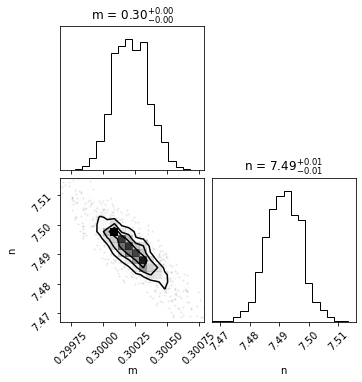

In [33]:
cornerplot(result)

In [35]:
np.savez("min_live_200", result)

In [33]:
np.savez("min_live_400", result)

In [23]:
result400 = np.load("min_live_400.npz",allow_pickle=True)

In [20]:
result400?

In [25]:
results400 = result400['arr_0']

In [36]:
results400

array({'niter': 7965, 'logz': -65.55970660085536, 'logzerr': 0.2861231510889259, 'logz_bs': -65.51671431522112, 'logz_single': -65.55970660085536, 'logzerr_tail': 0.009950023868526614, 'logzerr_bs': 0.2859500911244339, 'ess': 1583.1294012528324, 'H': 13.329508546165009, 'Herr': 0.11149753882347253, 'posterior': {'mean': [0.3002149962026744, 7.491382016824539], 'stdev': [0.00013730554260896666, 0.0059255343462038595], 'median': [0.3002129882016899, 7.491597147480445], 'errlo': [0.3000720060126749, 7.485222405349141], 'errup': [0.3003485045198131, 7.497284467874497], 'information_gain_bits': [4.14647919764959, 4.14647919764959]}, 'weighted_samples': {'upoints': array([[0.01639287, 0.20193325],
       [0.026723  , 0.06833019],
       [0.03327513, 0.11200955],
       ...,
       [0.30021522, 0.49828238],
       [0.30021926, 0.4982733 ],
       [0.30022042, 0.49826208]]), 'points': array([[0.01639287, 6.00966624],
       [0.026723  , 5.34165093],
       [0.03327513, 5.56004774],
       ...,